In [1]:
# 网页相关模块
import requests
import re
from bs4 import BeautifulSoup

# 数据分析模块
import pandas as pd
from datetime import datetime

# 数据可视化模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 可视化样式调节
mpl.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['.PingFang SC']  # 用来正常显示中文标签
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['lines.linewidth'] = 4.5
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 14
mpl.rcParams['font.size'] = 16

In [2]:
# 爬取网页
res = requests.get('http://www.shuichan.cc/article_list-144-663-1.html')
res.encoding = 'gb2312'

soup = BeautifulSoup(res.text, 'html5lib')
all_tags = soup.findAll("a")
p = re.compile('武汉')

# 获取所有武汉白沙洲水产市场的网站
wuhan_sites = []
for n, tag in enumerate(all_tags):
    try:
        wuhan = p.search(tag['title'])
        if wuhan:
            wuhan_sites.append(tag['href'])
    except KeyError:
        pass


In [3]:
# 读取数据
price_tables = []
print("有%d个网站需要爬取" % len(wuhan_sites))
for n, each_site in enumerate(wuhan_sites):
    print("正在爬取与处理第%d个网页的数据" % (n+1))
    data = pd.read_html('http://www.shuichan.cc/%s' % each_site)
    price_table = data[8]
    
    # 将第一行作为列名称
    new_header = price_table.iloc[0]

    price_table.columns = new_header

    price_table = price_table[1:]
    
    price_table = price_table.set_index('分类规格')
    
    price_tables.append(price_table)

有27个网站需要爬取
正在爬取与处理第1个网页的数据
正在爬取与处理第2个网页的数据
正在爬取与处理第3个网页的数据
正在爬取与处理第4个网页的数据
正在爬取与处理第5个网页的数据
正在爬取与处理第6个网页的数据
正在爬取与处理第7个网页的数据
正在爬取与处理第8个网页的数据
正在爬取与处理第9个网页的数据
正在爬取与处理第10个网页的数据
正在爬取与处理第11个网页的数据
正在爬取与处理第12个网页的数据
正在爬取与处理第13个网页的数据
正在爬取与处理第14个网页的数据
正在爬取与处理第15个网页的数据
正在爬取与处理第16个网页的数据
正在爬取与处理第17个网页的数据
正在爬取与处理第18个网页的数据
正在爬取与处理第19个网页的数据
正在爬取与处理第20个网页的数据
正在爬取与处理第21个网页的数据
正在爬取与处理第22个网页的数据
正在爬取与处理第23个网页的数据
正在爬取与处理第24个网页的数据
正在爬取与处理第25个网页的数据
正在爬取与处理第26个网页的数据
正在爬取与处理第27个网页的数据


In [4]:
def get_index_by_drop_duplicated_one(data):
    seen = set()
    for n, i in enumerate(data):
        if i not in seen:
            yield n
            seen.add(i)
            
def get_beautiful_date(date_list):
    seen = set()
    beautiful_list = []
    for date in date_list:
        p_date = datetime.strptime(date, '%m月%d日')
        if p_date.month in seen:
            beautiful_list.append("%d日" % p_date.day)
        else:
            beautiful_list.append("%d月\n%d日" % (p_date.month, p_date.day))
        seen.add(p_date.month)
        
    return beautiful_list

In [5]:
total_table = pd.concat(price_tables, axis=1, join='outer') # 合并
if "备注" in total_table:
    total_table.drop(columns="备注", inplace=True)

# 删除重复项
dci = list(get_index_by_drop_duplicated_one(total_table.columns))
total_table = total_table.iloc[:, dci]


In [6]:
# 去掉单位
for i in total_table:
    p = total_table[i].str.split('元', expand = True)[0]
    total_table[i] = p

In [7]:
total_table = total_table.applymap(int)

In [8]:
# 重新排序
get_p_date = lambda date: datetime.strptime(date, '%m月%d日')
p_dates = [get_p_date(date) for date in total_table.columns]
p_dates = sorted(p_dates)

get_f_date = lambda date: datetime.strftime(date, '%m月%-d日')
f_dates = [get_f_date(date) for date in p_dates]

total_table = total_table.reindex(f_dates, axis=1)

In [9]:
gl = lambda i: total_table.T.index.get_loc(i)

In [10]:
idmax = total_table.T.idxmax()
max_xy = zip(map(gl, idmax), total_table.T.max())
max_xy = list(max_xy)

In [11]:
# 精简列名称
total_table.columns
new_columns = get_beautiful_date(list(total_table.columns))
total_table.columns = new_columns

In [12]:
a = total_table.T['25-34克'].idxmax()

(24.5, 75)

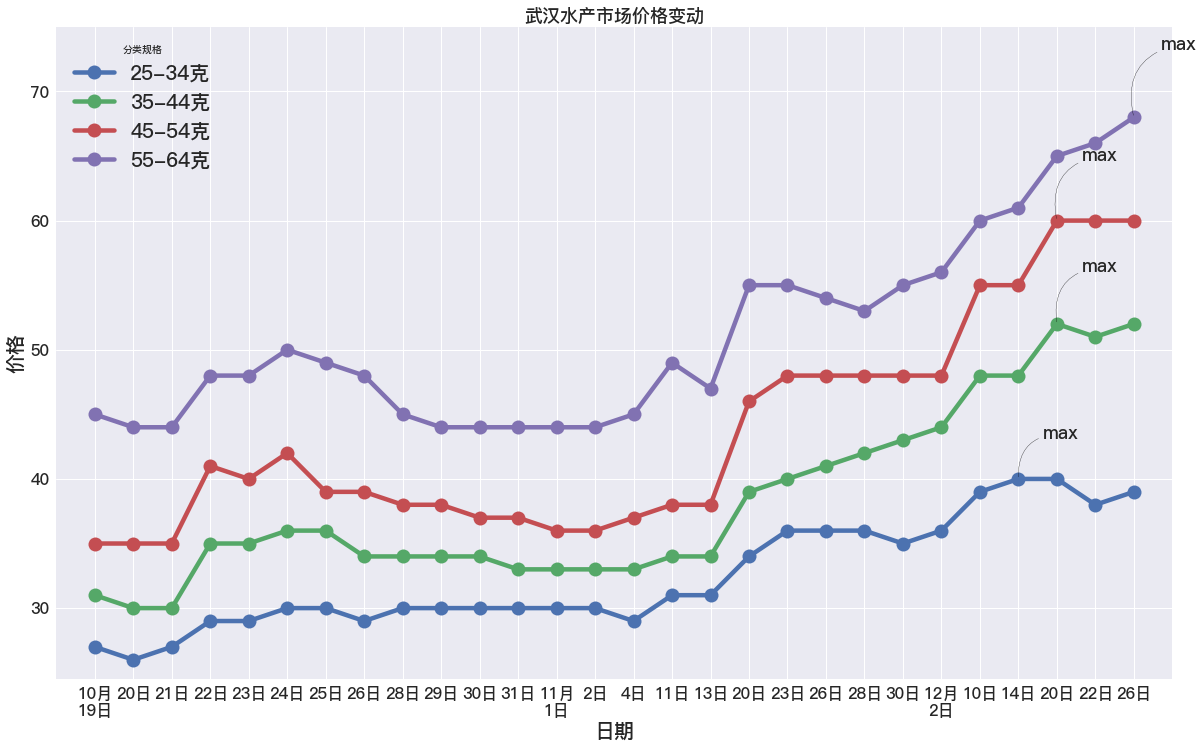

In [13]:
plot = total_table.T.plot(figsize=[20,12], fontsize=16, title='武汉水产市场价格变动', xticks=range(len(total_table.columns)), marker="o")
plot.set_ylabel('价格')
plot.set_xlabel('日期')
for xy in max_xy:
    plot.annotate('max', xy=xy, xycoords='data', xytext=xy,
                  textcoords='offset points', size=18,
                  arrowprops=dict(arrowstyle='-', connectionstyle="arc3,rad=.5"))
plot.set_xlim(-1, 28)
plot.set_ylim(24.5, 75)

In [14]:
fig = plot.get_figure()
fig.savefig('result.svg')

plt.show()

In [15]:
for xy in max_xy:
    print(xy)

(24, 40)
(25, 52)
(25, 60)
(27, 68)
